<a href="https://colab.research.google.com/github/dylanh05/pyDFT/blob/master/1DDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [ ]:
class DFT:
    # Space must be a 1D np.linspace and grid is equal length vector of values over the space
    # v_ext is the applied potential to the grid (only supports harmonic oscillator)
    # v_ext = 'harmonic' applies harmonic oscillator to the Hamiltonian
    def __init__(self, space, grid, v_ext):
        self.space = space
        self.dx = space[1] - space[0]
        self.grid = grid
        self.v_ext = v_ext

    # Plots the DFT grid on the 1D space it spans
    def plot_grid(self):
        print("DFT grid")
        plt.plot(self.space, self.grid)

    # Plots an arbitrary function on the DFT space, requires self.grid.size == function.size
    def plot_function_over_space(self, function):
        plt.plot(self.space, function)

    # Plots a state at a given index and the energy associated with it
    def plot_wavefuction(self, epsilon_n, psi_gn, ind):
        print("Energy: " + str(epsilon_n[ind]))
        plt.plot(space, psi_gn[:, ind])
        plt.show()

    # Gets the index of the first occurance of value in the DFT grid
    def get_index_grid(self, value):
        return np.where(self.grid==value)[0][0]

    # Gets the index of the state associated with the input energy
    def get_index_state(self, energy, epsilon_n):
        return np.where(energy == epsilon_n)[0][0]

    # Applies NxN operator to 1xN grid
    def linear_operator(self, operator):
        return np.dot(operator, self.grid)

    # Returns magnitde of a 1D vector
    def magnitude(self, vector):
        sum = 0
        for i in range(vector.size):
            sum += vector[i]**2
        return math.sqrt(sum)

    # Returns finite differences operator for single differentiation
    def deriv(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            if i != self.grid.size-1:
                operator[i][i+1] = -1
                operator[i+1][i] = 1
        operator = operator / (-2* self.dx)
        return operator

    # Returns finite differences operator for twice differentiation
    def deriv2(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            operator[i][i] = 1
            if i <= self.grid.size-3:
                operator[i][i+1] = -2
                operator[i][i+2] = 1
        operator = operator / ((self.dx)**2)
        return operator

    # Returns grids of first and second derivatives of grid over the DFT space
    def compute_derivs(self):
        first_derivs = self.linear_operator(self.deriv())
        second_derivs = self.linear_operator(self.deriv2())
        # The derivative get fuzzy at the endpoints, so we will exclude these
        first_derivs[0] = first_derivs[1]
        first_derivs[first_derivs.size-1] = first_derivs[first_derivs.size-2]
        second_derivs[0] = second_derivs[1]
        second_derivs[second_derivs.size-2:second_derivs.size] = second_derivs[second_derivs.size-3]
        return first_derivs, second_derivs


    # Integrates inputted function over the DFT grid, returns area under curve
    def integrate(self, function):
        dh = self.space[1]-self.space[0]
        area = 0
        for i in range(0, self.grid.size):
            area += function[i]*dh
        return area

    # Normalizes all states in psi_gn
    def normalize(self, psi_gn):
        for i in range(self.grid.size):
            area = self.integrate(np.abs(psi_gn[i])**2)
            psi_gn[i] = (np.abs(psi_gn[i])**2)/area
        return psi_gn

    # Gives the matrix representation of the kinetic operator applied to function over a grid
    # using the finite difference approximation
    # Approximations can be modified to use numerical differentiation contained within class
    def kinetic_operator(self):
        dx = self.space[1] - self.space[0]
        operator = self.deriv2()
        return (-1/2)*operator

    # Returns the external potential chosen as a matrix to apply to the hamiltonian
    def external_potential(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        if self.v_ext == "harmonic":
            for i in range(self.grid.size):
                operator[i][i] = self.grid[i]
            return operator
        print("External potential chosen: " + str(self.v_ext) + " not yet supported")

    # Formats potential into operator form to apply to the hamiltonian
    def potential(self, v):
        operator = np.zeros((self.space.size, self.space.size))
        for i in range(self.space.size):
            operator[i][i] = v[i]
        return operator

    # Returns the indices of n_states with lowest energy
    def find_ground_states(self, epsilon_n, n_elec):
        n_states = math.ceil(n_elec/2)
        lowest_energys = epsilon_n[np.argpartition(epsilon_n, n_states)[:n_states]]
        inds = []
        for i in range(n_states):
            inds.append(self.get_index_state(lowest_energys[i], epsilon_n))
        return inds

    # Returns list of electron occupation of each state in the DFT grid
    def get_electron_occupation(self, epsilon_n, n_elecs):
        inds = self.find_ground_states(epsilon_n,  n_elecs)
        occupation = [0 for i in range(self.space.size)]
        for i in range(0, n_elecs):
            occupation[inds[math.floor(i/2)]] += 1
        return occupation

    # Uses simple kinetic operator and potentials as the Hamiltonian, diagonalizes it, and computes Kohm Sham states
    def compute_Kohm_Sham_states(self, exc_potential):
        Hamiltonian = self.kinetic_operator() + self.external_potential() + self.potential(exc_potential)
        epsilon_n, psi_gn = np.linalg.eigh(Hamiltonian)
        
        # Numerical differentiation gets fuzzy at the endpoints, so we will set
        # these to an arbitrarily high energy so we dont consider these wavefunctions
        # in later DFT calculations
        epsilon_n[0] = 10000
        epsilon_n[epsilon_n.size-1] = 10000
        return epsilon_n, psi_gn

    # Returns the electron density of electrons on the DFT space, psi_gn must be normalized
    # This needs to be tested further
    def electron_density(self, epsilon_n, psi_gn_normalized, n_elecs):
        occupation = self.get_electron_occupation(epsilon_n, n_elecs)
        n = np.zeros(self.space.size)
        # Loop over every state
        for i in range(n.size):
            # Loop over every grid point
            for j in range(n.size):
                n[i] += occupation[j] * math.sqrt((psi_gn_normalized[j, i]**2))
        return n

    # Returns the exchange energy and potential using local density approximation, ignoring
    # correlation in the exchange functional for simplicity
    def compute_exchange(self, density):
        energy = self.integrate((-3/4)*((3/(math.pi)**(1/3)))*(density**(4/3)))
        potential = -(3/(math.pi))**(1/3)*(density**(1/3))
        return energy, potential

    # Still needs to be implemented
    #def compute_coulomb(self, density):
    #    energy = 6
    #    potential = 6
    #    return energy, potential

    # Self consistency cycle, loops until density converges using the following steps
    # 1. Compute exchange energy and potential from electron density
    # 2. Compute coulomb energy and potential from the electron density
    # 3. Construct the Hamiltonian using the potentials, harmonic external potential, and kinetic operator
    # 4. Compute wavefunctions and their corresponding energies from the Hamiltonian
    # 5. Compute density from normalized wavefunctions and the occupations given the number of electrons
    def scf_cycle(self, n_elecs, thresh, n_consec):
        last_density = np.zeros(self.space.size)
        change_in_density = np.ones(self.space.size)
        exc_energy = 10000
        change = 1000
        count = 0

        n_consec_consistent_loops = 0
        consec = False
        while n_consec_consistent_loops < n_consec:
            print("SCF cycle " + str(count))
            print("Exchange energy: " + str(exc_energy))
            exc_energy, exc_potential = self.compute_exchange(last_density)
            
            epsilon_n, psi_gn = self.compute_Kohm_Sham_states(exc_potential)
            psi_gn = State.normalize(psi_gn)
            density = self.electron_density(epsilon_n, psi_gn, n_elecs)
            
            print("Total kinetic energy: " + str(self.compute_kinetic_energy(epsilon_n, [exc_potential], density, self.get_electron_occupation(epsilon_n, n_elecs))))

            change = self.magnitude(density-last_density)
            print("Magnitude of density change: " + str(change))
            last_density = density
            count += 1

            if change < thresh*1000 and consec:
                n_consec_consistent_loops += 1
            elif change < thresh*1000 and not consec:
                n_consec_consistent_loops += 1
                consec = True
            elif change > thresh*1000:
                n_consec_consistent_loops = 0
                consec = False

        self.plot_function_over_space(last_density)

    # Still needs to be implemented
    # Returns the total kinetic energy
    # Potentials is a list of the potential grids, formatted
    # [exchange_potential, coulumb_potential]
    def compute_kinetic_energy(self, epsilon_n, potentials, density, occupation):
        if self.v_ext == "harmonic":
            v_ext = self.space**2
        total_potential = potentials[0] + v_ext #+ potentials[1]  Add in once coulumb potential is created
        kinetic_energy = 0
        for i in range(self.space.size):
            kinetic_energy += occupation[i]*epsilon_n[i]
        kinetic_energy -= self.integrate(total_potential*density)
        return kinetic_energy

    # Still needs to be implemented
    # Returns the total energy
    # Potentials is a list of the energys formatted
    # [exchange_energy, coulumb_energy]
    def compute_total_energy(self, epsilon_n, potentials, density, occupation, energys):
        kinetic_energy = self.compute_kinetic_energy(epsilon_n, potentials, density, occupation)
        total_energy = kinetic_energy + energys[0] #+ energys[1] + self.integrate(density*vexc)

In [ ]:
# First, we must contruct a space over which we will do the DFT calculation
n_partitions = 3000
space = np.linspace(0, 40, n_partitions)
print("1D DFT Space: ")
print(space)

1D DFT Space: 
[ 0.       0.01334  0.02668 ... 39.97332 39.98666 40.     ]


In [ ]:
# Next, we choose a DFT grid
x = np.sin(space)
print("DFT Grid: ")
print(x)

DFT Grid: 
[0.      0.01334 0.02667 ... 0.76264 0.75394 0.74511]


DFT grid


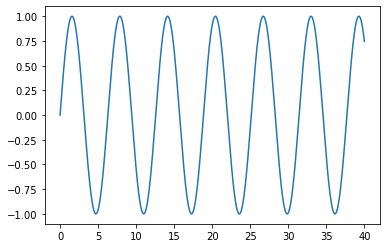

In [ ]:
# Initialize a DFT object over the space, with grid "x", and the harmonic external potential chosen
State = DFT(space, x, "harmonic")
# Look at the grid over the DFT space using the plot_grid() function
State.plot_grid()

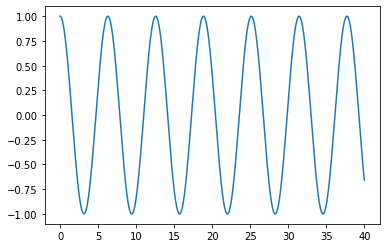

In [ ]:
# The DFT class has several functions that will be useful when doing DFT calculations
# Here is an example of one of such functions
first_derivs, second_derivs = State.compute_derivs()
State.plot_function_over_space(first_derivs)

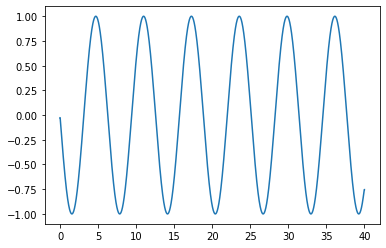

In [ ]:
State.plot_function_over_space(second_derivs)

In [ ]:
# Compute all of the states and the energies associated with each using compute_Kohm_Sham_states()
# To compute the states without the exchange potential, input the 0 matrix
exc_potential = np.zeros(State.space.size)
epsilon_n, psi_gn = State.compute_Kohm_Sham_states(exc_potential)

Energy: -2811.6252924310825


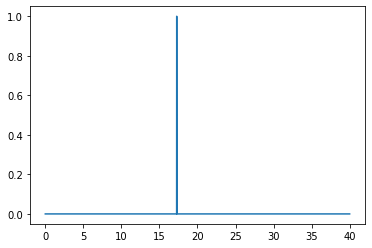

In [ ]:
# To view a state and the energy associated with it, use the plot_wavefunction() function
State.plot_wavefuction(epsilon_n, psi_gn, 5)

Integral over DFT space pre-normalization: 0.013337779259753251
Energy: -2811.6252924310825


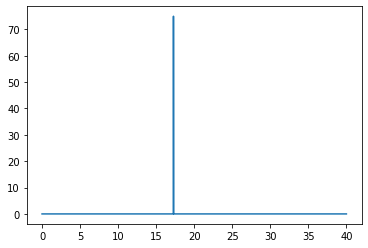

Integral over DFT space post-normalization: 0.9999999999999999


In [ ]:
# Wavefunctions must be normalized in most DFT calculations
# To normalize all wavefunctions on the grid, we can use the normalize() function
print("Integral over DFT space pre-normalization: " + str(State.integrate(psi_gn[5])))
psi_gn = State.normalize(psi_gn)
State.plot_wavefuction(epsilon_n, psi_gn, 5)
print("Integral over DFT space post-normalization: " + str(State.integrate(psi_gn[5])))

Electron density
Integral of electron density over the DFT space 6.999999999999999


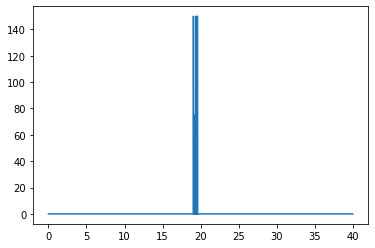

In [ ]:
# The electron density for n_elecs within the DFT grid can be easily calculated using electron_density()
n = State.electron_density(epsilon_n, psi_gn, 7)
print("Electron density")
plt.plot(space, n)
print("Integral of electron density over the DFT space " + str(State.integrate(n)))

In [ ]:
# Compute exchange potentials and energies using LDA approximation of the exchange functional using
# compute_exchange(), here a random density is chosen
density = np.random.rand(n_partitions)
energy, potential = State.compute_exchange(density)

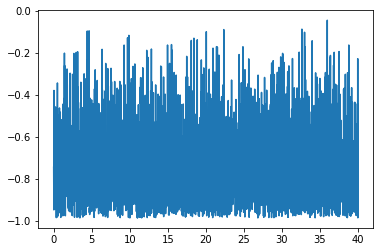

In [ ]:
State.plot_function_over_space(potential)

SCF cycle 0
Exchange energy: 10000
Total kinetic energy: -22297.795573357096
Magnitude of density change: 270.32620687791257
SCF cycle 1
Exchange energy: 0.0
Total kinetic energy: -22328.782166740453
Magnitude of density change: 382.29898803161905
SCF cycle 2
Exchange energy: -55.4482421766665
Total kinetic energy: -22293.014206740634
Magnitude of density change: 0.0
SCF cycle 3
Exchange energy: -55.4482421766665
Total kinetic energy: -22293.014206740634
Magnitude of density change: 0.0
SCF cycle 4
Exchange energy: -55.4482421766665
Total kinetic energy: -22293.014206740634
Magnitude of density change: 0.0
SCF cycle 5
Exchange energy: -55.4482421766665
Total kinetic energy: -22293.014206740634
Magnitude of density change: 0.0
SCF cycle 6
Exchange energy: -55.4482421766665
Total kinetic energy: -22293.014206740634
Magnitude of density change: 0.0


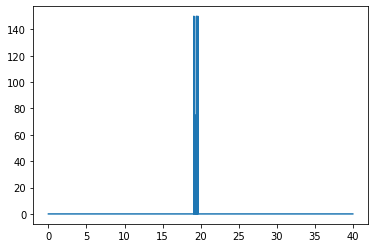

In [ ]:
# The self consitency field cycle updates the density until it becomes "self-consistent",
# ie, it changes less than a certain threshold for n_consec iterations
State.scf_cycle(7, .6, 7) 

Electron density


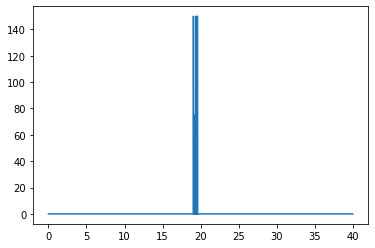

In [ ]:
n = State.electron_density(epsilon_n, psi_gn, 7)
print("Electron density")
plt.plot(space, n)